In [28]:
!pip install langchain langgraph cassio

In [29]:
import cassio
from google.colab import userdata
ASTRA_DB_APPLICATION_TOKEN = userdata.get("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = userdata.get("ASTRA_DB_ID")
cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id= ASTRA_DB_ID
)


In [30]:
!pip install langchain_community langchain_groq tiktoken langchainhub langchain langchain_huggingface

In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

In [32]:
urls = [
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/"
]

In [33]:
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

In [34]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000, chunk_overlap=0)

In [35]:
texts = text_splitter.split_documents(doc_list)

In [36]:
from langchain_huggingface import HuggingFaceEmbeddings

In [37]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [38]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(
    embedding=embeddings,
    table_name='qa_mini_demo',
    session=None,
    keyspace=None
)

In [39]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

In [40]:
astra_vector_store.add_documents(texts)

['519465a667bf40c9b0ba62f2b3cc001b',
 '9fb6078f745747438ef67d204b398bab',
 '2a21cbee63ea4118b3f95068f27ed365',
 'd6f6eb6519c341998e3d2cfceb450829',
 'c0c702ae2c2e4671bbbe694e37bc54f2',
 'a3cba6131199498082681183fdbbc282',
 '6afd71cefde14b9db28549e2df7ee16e',
 '8a6a744f167c467fb9ff9e30467b50bf',
 '0d3bda53a92149d6b777d421ff1c03ed',
 '59760dc963e34c4bba3c552f5a937a35',
 '713030009ad04f11926a26b23cfbce8a',
 '1cd3c4e45d0b4c789f9a8dc67c4aa334',
 '06728a4827a544dfbda335eb99fbba16',
 '616220777077401e89a9143a40aea2f1',
 '7dcdeb5a6fe74b1692b26f30e5cf8a3f',
 'cab4328da13a4030a84567e2c56c5752',
 '0cfd0d0e54264e11bea40a689891213d',
 '4141329cfe1d49e98d458cbb1f181182',
 'be64f81a62f74373adbec1bde5ae97f4',
 '118204f4cd4741a3aa2169bfbf2b0cec',
 '73921520ddbb42459982c8d6a424f3d4',
 '69475f1e785f4662ad2adec998444644',
 'f8dc1aabe969421db868482c1c855e62',
 '69b57cae0d7d48768abd5c7419bf3df9',
 '4fb1ebfc376f4d40b183d8bc462e3970',
 '1eb41807c9f24a6ebe8b7b1d6ef17e44']

In [41]:
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

In [42]:
retriever = astra_vector_store.as_retriever()

In [43]:
retriever.invoke("what is fine tuning")

[Document(metadata={'description': 'Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/', 'title': "Diffusion Models for Video Generation | Lil'Log"}, page_content='Fig. 8. The Tune-A-Video architecture overview. It first runs a light-weighted fine-tuning stage on a single video before the sampling stage. Note that the entire temporal self-attention (T-Attn) layers get fine-tuned because they are newly added, but only query projections in ST-Attn and Cross-Attn are updated during fine-tuning to pr

In [44]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [45]:
class RouteQuery(BaseModel):
  datasource: Literal["vectorstore", "wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore"
  )

In [48]:
from google.colab import userdata
import os
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

In [58]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama-3.1-70b-Versatile")

In [59]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f6ff40a9ea0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f6ff40a91b0>, model_name='Llama-3.1-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [60]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [61]:
system="""
You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for question on these topics. Otherwise, use wiki-search
"""
route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

In [62]:
question_router = route_prompt | structured_llm_router

In [63]:
print(question_router.invoke({
    "question": "What is agent?"
}))

datasource='vectorstore'


In [64]:
print(question_router.invoke({
    "question": "Who is rophnan?"
}))

datasource='wiki_search'


In [65]:
!pip install langchain_community
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=2ad923c0380ddd3092f92797bbd63a9b9e771222c1ff0aad0ed0ddffcfc0496a
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [67]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

In [68]:
api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [70]:
wiki.run("who is rophnan")

"Page: Rophnan\nSummary: Rophnan Nuri Muzeyin (Ge'ez: ሮፍናን ኑሪ ሙዘይን; born 22 June 1990), known mononymously as Rophnan (stylized as all caps), is an Ethiopian musician. Rophnan entered into the mainstrea"

In [71]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  question: str
  generation: str
  documents: List[str]


In [74]:
from langchain.schema import Document

def retrieve(state):
  questions = state["question"]
  documents = retriever.invoke(questions)
  return {"documents": documents, "question": question}

In [97]:
def wiki_search(state):
  question = state["question"]
  docs = wiki.invoke({"query": question})
  wiki_results = docs
  wiki_results = Document(page_content=wiki_results)
  return {"documents": wiki_results, "question": question}

In [100]:
def route(state):
  question=state["question"]
  source = question_router.invoke({"question": question})
  if source.datasource == "wiki_search":
    return "wiki_search"
  elif source.datasource == "vectorstore":
    return "vectorstore"

In [101]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

In [102]:
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)

workflow.add_conditional_edges(
    START,
    route,
     {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve"}
)

In [103]:
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

In [104]:
app = workflow.compile()

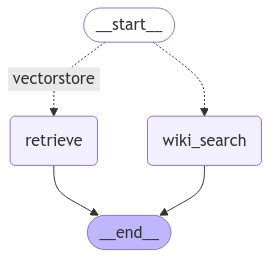

In [105]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
while True:
  user_input = input("User: ")
  if user_input.lower() in ["quit", "q"]:
    print("Good Bye")
    break
  for event in app.stream({"question": user_input}):
    print(event.values())
    for value in event.values():
      print(value['documents'])


User: who is rophnan
dict_values([{'question': 'who is rophnan', 'documents': Document(metadata={}, page_content="Page: Rophnan\nSummary: Rophnan Nuri Muzeyin (Ge'ez: ሮፍናን ኑሪ ሙዘይን; born 22 June 1990), known mononymously as Rophnan (stylized as all caps), is an Ethiopian musician. Rophnan entered into the mainstrea")}])
page_content='Page: Rophnan
Summary: Rophnan Nuri Muzeyin (Ge'ez: ሮፍናን ኑሪ ሙዘይን; born 22 June 1990), known mononymously as Rophnan (stylized as all caps), is an Ethiopian musician. Rophnan entered into the mainstrea'
